# IEEE-CIS Fraud Detection: EDA and models

Kaggle [IEEE-CIS Fraud Detection][kaggle] において、
[EDA and models][artgor] をベースに利用しています。
多くの場所は写経となっています。
StratifiedKFoldによる分割での精度確認です。


[kaggle]: https://www.kaggle.com/c/ieee-fraud-detection/
[artgor]: https://www.kaggle.com/artgor/eda-and-models

## Add packages

In [0]:
!pip install kaggle

## Import

In [0]:
# default packages
import gc
import logging
import pathlib
import pprint
import time
import typing as t

In [0]:
# third party packages
import google.colab.drive as drive
import IPython.display as display
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import sklearn.preprocessing as preprocessing
import tqdm.notebook as tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# auto reload
%load_ext autoreload
%autoreload 2

In [0]:
# logger
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [0]:
# graph settings
sns.set()

## Directory structure

In [0]:
data_dir = pathlib.Path("data")
raw_dir = data_dir.joinpath("raw")
processed_dir = data_dir.joinpath("processed")

data_dir.mkdir(exist_ok=True)
raw_dir.mkdir(exist_ok=True)
processed_dir.mkdir(exist_ok=True)

## Mount google drive

In [0]:
def mount_gdrive() -> pathlib.Path:
    """Google Drive をマウントし、必要なディレクトリへのシンボリックリンクを設定する."""
    gdrive_base = pathlib.Path("/content/drive")
    gdrive_cache = gdrive_base.joinpath("My Drive/storeItemDemandForecastingChallenge")
    gdrive_kaggle = gdrive_base.joinpath("My Drive/kaggle")

    kaggle_dir = pathlib.Path("./kaggle")
    cache_dir = pathlib.Path("./cache")

    if gdrive_base.exists() is False:
        drive.mount(str(gdrive_base))
    if cache_dir.exists() is False:
        !ln -s "$gdrive_cache" "$cache_dir"
    if kaggle_dir.exists() is False:
        !ln -s "$gdrive_kaggle" "$kaggle_dir"

    return cache_dir, kaggle_dir


cache_dir, kaggle_dir = mount_gdrive()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Enable kaggle API

In [0]:
def activate_kaggle_api(gdrive_kaggle: pathlib.Path) -> None:
    """Kaggle API を有効化するための token を Google Drive からコピーする."""
    kaggle_file = "kaggle.json"
    gdrive_kaggle_json = gdrive_kaggle.joinpath(kaggle_file)
    local_kaggle_dir = pathlib.Path("/root/.kaggle")
    local_kaggle_json = local_kaggle_dir.joinpath(kaggle_file)

    local_kaggle_dir.mkdir(exist_ok=True)
    !cp "$gdrive_kaggle_json" "$local_kaggle_json"
    !chmod 600 "$local_kaggle_json"


activate_kaggle_api(kaggle_dir)

## Load dataset

In [0]:
competition_name = "ieee-fraud-detection"
!kaggle competitions download -c "$competition_name" -p "$raw_dir"

  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 53.1MB/s]
 73% 38.0M/52.2M [00:00<00:00, 67.8MB/s]
100% 52.2M/52.2M [00:00<00:00, 132MB/s] 
 84% 49.0M/58.3M [00:00<00:00, 74.7MB/s]
100% 58.3M/58.3M [00:00<00:00, 119MB/s] 
  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 107MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 166MB/s]


In [0]:
def load_dataset() -> t.Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Notes:
        - id-xx の部分が train と test で異なるため、一致するように修正を行う。
    """
    train_identity = pd.read_csv(raw_dir.joinpath("train_identity.csv.zip"))
    train_transaction = pd.read_csv(raw_dir.joinpath("train_transaction.csv.zip"))
    
    test_identity = pd.read_csv(raw_dir.joinpath("test_identity.csv.zip"))
    test_transaction = pd.read_csv(raw_dir.joinpath("test_transaction.csv.zip"))
    
    sub = pd.read_csv(raw_dir.joinpath("sample_submission.csv.zip"))

    train = pd.merge(train_transaction, train_identity, on="TransactionID", how="left")
    train.columns = [name.replace("-", "_") for name in train.columns]

    test = pd.merge(test_transaction, test_identity, on="TransactionID", how="left")
    test.columns = [name.replace("-", "_") for name in test.columns]

    return train, test, sub


df_train_org, df_test_org, df_sub_org = load_dataset()

## Show dataset info

In [0]:
# show train dataset
display.display(df_train_org.head())
display.display(df_train_org.tail())
logger.info(df_train_org.info())

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,272.0,87.0,48.0,NaN,NaN,NaN,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,231.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,debit,387.0,87.0,3.0,NaN,aol.com,NaN,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,1.0,5.0,1.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590539,3577539,0,15811131,279.95,W,15066,170.0,150.0,mastercard,102.0,credit,299.0,87.0,NaN,NaN,gmail.com,NaN,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


INFO:__main__:None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


In [0]:
# show test dataset
display.display(df_test_org.head())
display.display(df_test_org.tail())
logger.info(df_test_org.info())

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
506686,4170235,34214279,94.679,C,13832,375.0,185.0,mastercard,224.0,debit,284.0,60.0,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506687,4170236,34214287,12.173,C,3154,408.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,157.0,hotmail.com,hotmail.com,1.0,3.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0,1.0,1.0,3.0,1.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,NaN,NaN,0.0,...,-45.0,266704.0,NaN,NaN,-3.0,-10.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 43.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,ALE-L23 Build/HuaweiALE-L23
506688,4170237,34214326,49.000,W,16661,490.0,150.0,visa,226.0,debit,327.0,87.0,NaN,NaN,hotmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506689,4170238,34214337,202.000,W,16621,516.0,150.0,mastercard,224.0,debit,177.0,87.0,NaN,NaN,hotmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506690,4170239,34214345,24.346,C,5713,168.0,144.0,visa,147.0,credit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,29.958332,0.958333,0.0,...,-10.0,692090.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,NaN,266.0,127.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,samsung browser 8.2,NaN,NaN,NaN,F,F,T,F,mobile,SAMSUNG


INFO:__main__:None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 0 to 506690
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 1.6+ GB


In [0]:
# show submission dataset
display.display(df_sub_org.head())
display.display(df_sub_org.tail())
logger.info(df_sub_org.info())

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


,TransactionID,isFraud
506686,4170235,0.5
506687,4170236,0.5
506688,4170237,0.5
506689,4170238,0.5
506690,4170239,0.5


INFO:__main__:None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  506691 non-null  int64  
 1   isFraud        506691 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 7.7 MB


In [0]:
def show_column_set(df_train: pd.DataFrame, df_test: pd.DataFrame) -> None:
    cols_train = df_train.columns
    cols_test = df_test.columns

    cols_sub1 = set(cols_train) - set(cols_test)
    cols_sub2 = set(cols_test) - set(cols_train)

    logger.info(pprint.pformat(cols_sub1))
    logger.info(pprint.pformat(cols_sub2))


show_column_set(df_train_org, df_test_org)

INFO:__main__:{'isFraud'}
INFO:__main__:set()


In [0]:
def missing_values(df: pd.DataFrame) -> None:
    columns = df.isnull().any().sum()
    logger.info(f"There are {columns} columns in dataset with missing values.")

missing_values(df_train_org)
missing_values(df_test_org)

INFO:__main__:There are 414 columns in dataset with missing values.
INFO:__main__:There are 385 columns in dataset with missing values.


In [0]:
def one_value_columns(df: pd.DataFrame) -> None:
    columns = [name for name in df.columns if len(df[name].unique()) < 2]
    logger.info(f"There are {len(columns)} columns in dataset withone uqnie values.")
    logger.info(f"unique columns: {columns}")


one_value_columns(df_train_org)
one_value_columns(df_test_org)

INFO:__main__:There are 0 columns in dataset withone uqnie values.
INFO:__main__:unique columns: []
INFO:__main__:There are 1 columns in dataset withone uqnie values.
INFO:__main__:unique columns: ['V107']


## Data Exploration

## Feature Engineering

In [0]:
def create_feature(df_source: pd.DataFrame) -> pd.DataFrame:
    def group_div(target: pd.DataFrame, name: str, group: str, method: str) -> pd.Series:
        denom = target.groupby([group])[name].transform(method)
        return target[name] / denom

    df = df_source.copy()

    df["TransactionAmt_to_mean_card1"] = group_div(df_source, "TransactionAmt", "card1", "mean")
    df["TransactionAmt_to_std_card1"] = group_div(df_source, "TransactionAmt", "card1", "std")
    df["TransactionAmt_to_mean_card4"] = group_div(df_source, "TransactionAmt", "card4", "mean")
    df["TransactionAmt_to_std_card4"] = group_div(df_source, "TransactionAmt", "card4", "std")

    df["id_02_to_mean_card1"] = group_div(df_source, "id_02", "card1", "mean")
    df["id_02_to_std_card1"] = group_div(df_source, "id_02", "card1", "std")
    df["id_02_to_mean_card4"] = group_div(df_source, "id_02", "card4", "mean")
    df["id_02_to_std_card4"] = group_div(df_source, "id_02", "card4", "std")

    df["D15_to_mean_card1"] = group_div(df_source, "D15", "card1", "mean")
    df["D15_to_std_card1"] = group_div(df_source, "D15", "card1", "std")
    df["D15_to_mean_card4"] = group_div(df_source, "D15", "card4", "mean")
    df["D15_to_std_card4"] = group_div(df_source, "D15", "card4", "std")

    df["D15_to_mean_addr1"] = group_div(df_source, "D15", "addr1", "mean")
    df["D15_to_std_addr1"] = group_div(df_source, "D15", "addr1", "std")
    df["D15_to_mean_addr2"] = group_div(df_source, "D15", "addr2", "mean")
    df["D15_to_std_addr2"] = group_div(df_source, "D15", "addr2", "std")

    df[["P_emaildomain_1", "P_emaildomain_2", "P_emaildomain_3"]] = df_source["P_emaildomain"].str.split(".", expand=True)
    df[["R_emaildomain_1", "R_emaildomain_2", "R_emaildomain_3"]] = df_source["R_emaildomain"].str.split(".", expand=True)

    return df

In [0]:
%time df_train_fe = create_feature(df_train_org)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


CPU times: user 4.47 s, sys: 135 ms, total: 4.6 s
Wall time: 4.6 s


In [0]:
display.display(df_train_fe.head())
display.display(df_train_fe.tail())
logger.info(df_train_fe.info())

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionAmt_to_mean_card1,TransactionAmt_to_std_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card4,id_02_to_mean_card1,id_02_to_std_card1,id_02_to_mean_card4,id_02_to_std_card4,D15_to_mean_card1,D15_to_std_card1,D15_to_mean_card4,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1,D15_to_mean_addr2,D15_to_std_addr2,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.194640,0.184566,0.257761,0.170233,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.123777,0.062995,0.219054,0.114212,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,gmail,com,None,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.608150,0.589241,0.443070,0.258544,NaN,NaN,NaN,NaN,2.518583,1.851016,1.865915,1.541448,1.611525,1.486472,1.721392,1.522249,outlook,com,None,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.405133,0.259447,0.377679,0.196917,NaN,NaN,NaN,NaN,0.550272,0.520531,0.720057,0.558392,0.686169,0.576638,0.606586,0.536412,yahoo,com,None,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0.515612,0.882933,0.377679,0.196917,0.764773,1.753301,0.373295,0.425884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gmail,com,None,NaN,NaN,NaN


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionAmt_to_mean_card1,TransactionAmt_to_std_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card4,id_02_to_mean_card1,id_02_to_std_card1,id_02_to_mean_card4,id_02_to_std_card4,D15_to_mean_card1,D15_to_std_card1,D15_to_mean_card4,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1,D15_to_mean_addr2,D15_to_std_addr2,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,272.0,87.0,48.0,NaN,NaN,NaN,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.505177,0.363843,0.367973,0.214723,NaN,NaN,NaN,NaN,0.307857,0.269218,0.331718,0.274035,0.330520,0.276139,0.306025,0.270622,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.163195,0.402579,0.298366,0.155564,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,gmail,com,None,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,231.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.258474,0.203942,0.233783,0.121891,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,gmail,com,None,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,debit,387.0,87.0,3.0,NaN,aol.com,NaN,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,1.0,5.0,1.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.953051,0.662777,0.883768,0.460785,NaN,NaN,NaN,NaN,0.108422,0.106296,0.142714,0.110672,0.127389,0.109010,0.120224,0.106316,aol,com,None,NaN,NaN,NaN
590539,3577539,0,15811131,279.95,W,15066,170.0,150.0,mastercard,102.0,credit,299.0,87.0,NaN,NaN,gmail.com,NaN,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.333976,0.899892,2.114622,1.102536,NaN,NaN,NaN,NaN,0.008034,0.005348,0.006487,0.005031,0.005946,0.004884,0.005465,0.004833,gmail,com,None,NaN,NaN,NaN


INFO:__main__:None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 456 entries, TransactionID to R_emaildomain_3
dtypes: float64(415), int64(4), object(37)
memory usage: 2.0+ GB


In [0]:
%time df_test_fe = create_feature(df_test_org)

CPU times: user 3.72 s, sys: 96.6 ms, total: 3.81 s
Wall time: 3.79 s


In [0]:
display.display(df_test_fe.head())
display.display(df_test_fe.tail())
logger.info(df_test_fe.info())

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionAmt_to_mean_card1,TransactionAmt_to_std_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card4,id_02_to_mean_card1,id_02_to_std_card1,id_02_to_mean_card4,id_02_to_std_card4,D15_to_mean_card1,D15_to_std_card1,D15_to_mean_card4,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1,D15_to_mean_addr2,D15_to_std_addr2,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.339332,0.260350,0.237290,0.129831,NaN,NaN,NaN,NaN,1.066067,1.665603,1.925444,1.502141,1.557394,1.450810,1.760048,1.477451,gmail,com,None,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333494,0.134271,0.363919,0.199114,NaN,NaN,NaN,NaN,2.155230,2.047675,2.984674,2.328502,3.033737,2.300422,2.728290,2.290230,aol,com,None,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.485504,1.895771,1.270002,0.694869,NaN,NaN,NaN,NaN,0.279881,0.339451,0.456646,0.356253,0.457103,0.351657,0.417420,0.350398,hotmail,com,None,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.969653,1.913954,2.116298,1.157912,NaN,NaN,NaN,NaN,1.578683,1.130023,1.139260,0.888797,1.020278,0.901970,1.041398,0.874189,gmail,com,None,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.567364,0.310151,0.517674,0.277467,NaN,NaN,NaN,NaN,0.085873,0.075361,0.109654,0.083425,0.098978,0.080181,0.094673,0.079472,gmail,com,None,NaN,NaN,NaN


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionAmt_to_mean_card1,TransactionAmt_to_std_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card4,id_02_to_mean_card1,id_02_to_std_card1,id_02_to_mean_card4,id_02_to_std_card4,D15_to_mean_card1,D15_to_std_card1,D15_to_mean_card4,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1,D15_to_mean_addr2,D15_to_std_addr2,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3
506686,4170235,34214279,94.679,C,13832,375.0,185.0,mastercard,224.0,debit,284.0,60.0,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.771274,2.786783,0.721308,0.386612,NaN,NaN,NaN,NaN,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,gmail,com,None,gmail,com,None
506687,4170236,34214287,12.173,C,3154,408.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,157.0,hotmail.com,hotmail.com,1.0,3.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0,1.0,1.0,3.0,1.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 43.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,ALE-L23 Build/HuaweiALE-L23,0.360082,0.369440,0.092739,0.049707,0.872946,1.422157,1.220024,1.403943,0.24353,0.104885,0.079748,0.060673,NaN,NaN,NaN,NaN,hotmail,com,None,hotmail,com,None
506688,4170237,34214326,49.000,W,16661,490.0,150.0,visa,226.0,debit,327.0,87.0,NaN,NaN,hotmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.424053,0.280924,0.363919,0.199114,NaN,NaN,NaN,NaN,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,hotmail,com,None,NaN,NaN,NaN
506689,4170238,34214337,202.000,W,16621,516.0,150.0,mastercard,224.0,debit,177.0,87.0,NaN,NaN,hotmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.315186,2.640523,1.538928,0.824846,NaN,NaN,NaN,NaN,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,hotmail,com,None,NaN,NaN,NaN
506690,4170239,34214345,24.346,C,5713,168.0,144.0,visa,147.0,credit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,29.958332,0.958333,0.0,...,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,samsung browser 8.2,NaN,NaN,NaN,F,F,T,F,mobile,SAMSUNG,0.162994,0.091806,0.180816,0.098931,3.020494,3.254803,3.673150,3.805817,0.00000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,hotmail,com,None,hotmail,com,None


INFO:__main__:None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 0 to 506690
Columns: 455 entries, TransactionID to R_emaildomain_3
dtypes: float64(415), int64(3), object(37)
memory usage: 1.7+ GB


## Prepare data for modeling

In [0]:
def many_null_cols(df: pd.DataFrame) -> t.List[str]:
    threshold = 0.9
    return [
        name for name in df.columns
        if df[name].isnull().sum() / df.shape[0] > threshold
    ]


def big_top_value_cols(df: pd.DataFrame) -> t.List[str]:
    threshold = 0.9
    return [
        name for name in df.columns
        if df[name].value_counts(dropna=False, normalize=True).values[0] > threshold
    ]


def drop_columns(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame
) -> t.Tuple[pd.DataFrame, pd.DataFrame]:


    many_null_cols_train = many_null_cols(df_train)
    many_null_cols_test = many_null_cols(df_test)
    big_top_value_train = big_top_value_cols(df_train)
    big_top_value_test = big_top_value_cols(df_test)
    drop_cols = list(set(
        many_null_cols_train
        + many_null_cols_test
        + big_top_value_train
        + big_top_value_test
    ))
    drop_cols.remove("isFraud")

    logger.info(f"drop num: {len(drop_cols)}")
    logger.info(f"drop columns: {pprint.pformat(drop_cols)}")

    return (
        df_train.drop(drop_cols, axis=1),
        df_test.drop(drop_cols, axis=1)
    )


%time df_train_droped, df_test_droped = drop_columns(df_train_fe, df_test_fe)

INFO:__main__:drop num: 84
INFO:__main__:drop columns: ['V101',
 'V105',
 'V300',
 'V290',
 'V77',
 'V133',
 'V98',
 'V321',
 'V25',
 'V67',
 'id_24',
 'V102',
 'C3',
 'V116',
 'V284',
 'V89',
 'V135',
 'id_23',
 'V137',
 'V112',
 'V123',
 'V114',
 'V120',
 'V65',
 'V104',
 'id_21',
 'id_18',
 'V132',
 'V66',
 'V121',
 'V319',
 'V28',
 'V320',
 'V119',
 'V118',
 'id_07',
 'V107',
 'V299',
 'V103',
 'V298',
 'V14',
 'V68',
 'id_08',
 'V134',
 'V106',
 'V293',
 'V24',
 'V86',
 'V108',
 'V23',
 'V318',
 'id_22',
 'V309',
 'id_27',
 'V109',
 'V27',
 'P_emaildomain_3',
 'R_emaildomain_3',
 'D7',
 'V129',
 'V136',
 'V110',
 'V125',
 'V286',
 'V115',
 'V297',
 'V311',
 'V281',
 'V111',
 'V55',
 'V305',
 'V295',
 'V316',
 'id_25',
 'dist2',
 'id_26',
 'V113',
 'V301',
 'V88',
 'V122',
 'V26',
 'V117',
 'V124',
 'V296']


CPU times: user 14.8 s, sys: 829 ms, total: 15.6 s
Wall time: 15.6 s


In [0]:
def label_encoding(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
) -> t.Tuple[pd.DataFrame, pd.DataFrame]:
    categorical_cols = [
        *[f"id_{num}" for num in range(12, 39)],
        *[f"card{num}" for num in range(1, 7)],
        *[f"addr{num}" for num in range(1, 3)],
        *[f"M{num}" for num in range(1, 10)],
        'P_emaildomain',
        *[f"P_emaildomain_{num}" for num in range(1, 4)],
        'R_emaildomain',
        *[f"R_emaildomain_{num}" for num in range(1, 4)],
        'DeviceType',
        'DeviceInfo',
        'ProductCD',
    ]
    categorical_cols = [
        name for name in categorical_cols
        if name in df_train.columns
    ]

    df_train_enc = df_train.copy()
    df_test_enc = df_test.copy()
    for name in categorical_cols:
        le = preprocessing.LabelEncoder()
        train_list = df_train[name].astype(str).to_list()
        test_list = list()
        if name in df_test.columns:
            test_list = df_test[name].astype(str).to_list()
        le.fit(train_list + test_list)

        df_train_enc[name] = le.transform(df_train[name].astype(str).to_list())
        if name in df_test.columns:
            df_test_enc[name] = le.transform(df_test[name].astype(str).to_list())

    return df_train_enc, df_test_enc


%time df_train_encoded, df_test_encoded = label_encoding(df_train_droped, df_test_droped)

CPU times: user 1min 9s, sys: 3.82 s, total: 1min 13s
Wall time: 1min 13s


In [0]:
def clean_inf_nan(df: pd.DataFrame) -> pd.DataFrame:
    return df.replace([np.inf, -np.inf], np.nan)


def create_train_test_set(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
) -> None:
    train_sorted = df_train.sort_values("TransactionDT")
    train_x = train_sorted.drop(["isFraud", "TransactionDT", "TransactionID"], axis=1)
    train_x = clean_inf_nan(train_x)
    train_y = train_sorted["isFraud"]

    test_x = df_test.drop(["TransactionDT", "TransactionID"], axis=1)
    test_x = clean_inf_nan(test_x)
    test_index = df_test[["TransactionDT", "TransactionID"]]

    return train_x, train_y, test_x, test_index


%time df_train_x, df_train_y, df_test_x, df_test_index = \
    create_train_test_set(df_train_encoded, df_test_encoded)

CPU times: user 4.62 s, sys: 3.29 s, total: 7.92 s
Wall time: 7.94 s


In [0]:
# del df_train_fe
# del df_test_fe
# del df_train_droped
# del df_test_droped
# del df_train_encoded
# del df_test_encoded

gc.collect()

302

## LGBM

### Training

In [0]:
def train_lightgbm(df_x: pd.DataFrame, df_y: pd.DataFrame) -> t.Dict:
    n_fold = 5
    folds = model_selection.StratifiedKFold(n_splits=n_fold)
    params = {
        "num_leaves": 256,
        "min_child_samples": 79,
        "objective": "binary",
        "max_depth": 13,
        "learning_rate": 0.03,
        "boosting_type": "gbdt",
        "subsample_freq": 3,
        "subsample": 0.9,
        "bagging_seed": 11,
        "metric": "auc",
        "verbosity": -1,
        "reg_alpha": 0.3,
        "reg_lambda": 0.3,
        "colsample_bytree": 0.9,
    }
    verbose = 500
    early_stopping_rounds = 200
    n_estimators = 5000
    averaging = "usual"
    n_jobs = -1

    oof = np.zeros((len(df_x), 1))
    scores = list()
    models = list()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(df_x, df_y)):
        logger.info(f"Fold {fold_n + 1} started at {time.ctime()}")

        x_train, x_valid = df_x.iloc[train_index], df_x.iloc[valid_index]
        y_train, y_valid = df_y.iloc[train_index], df_y.iloc[valid_index]

        model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs=n_jobs)
        model.fit(
            x_train,
            y_train,
            eval_set=[(x_train, y_train), (x_valid, y_valid)],
            verbose=verbose,
            early_stopping_rounds=early_stopping_rounds,
        )
        y_pred_valid = model.predict_proba(x_valid)[:, 1]

        models.append(model)
        oof[valid_index] = y_pred_valid.reshape(-1, 1)
        scores.append(metrics.roc_auc_score(y_valid, y_pred_valid))

    logger.info(f"CV mean score: {np.mean(scores):.4f}, std: {np.std(scores):.4f}")

    result = dict(models=models, oof=oof, scores=scores)
    return result


%time result = train_lightgbm(df_train_x, df_train_y)

INFO:__main__:Fold 1 started at Sun Apr 12 03:51:57 2020


Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.994614	valid_1's auc: 0.915815
Early stopping, best iteration is:
[511]	training's auc: 0.994774	valid_1's auc: 0.915984


INFO:__main__:Fold 2 started at Sun Apr 12 04:00:07 2020


Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.994317	valid_1's auc: 0.939605
Early stopping, best iteration is:
[693]	training's auc: 0.997239	valid_1's auc: 0.940322


INFO:__main__:Fold 3 started at Sun Apr 12 04:10:20 2020


Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.994691	valid_1's auc: 0.927056
Early stopping, best iteration is:
[375]	training's auc: 0.991076	valid_1's auc: 0.927533


INFO:__main__:Fold 4 started at Sun Apr 12 04:16:56 2020


Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.994577	valid_1's auc: 0.948504
Early stopping, best iteration is:
[511]	training's auc: 0.99477	valid_1's auc: 0.948583


INFO:__main__:Fold 5 started at Sun Apr 12 04:24:49 2020


Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.995148	valid_1's auc: 0.92392
Early stopping, best iteration is:
[420]	training's auc: 0.993369	valid_1's auc: 0.924337


INFO:__main__:CV mean score: 0.9314, std: 0.0116


CPU times: user 2h 36min 20s, sys: 22.4 s, total: 2h 36min 42s
Wall time: 39min 56s


### feature importance

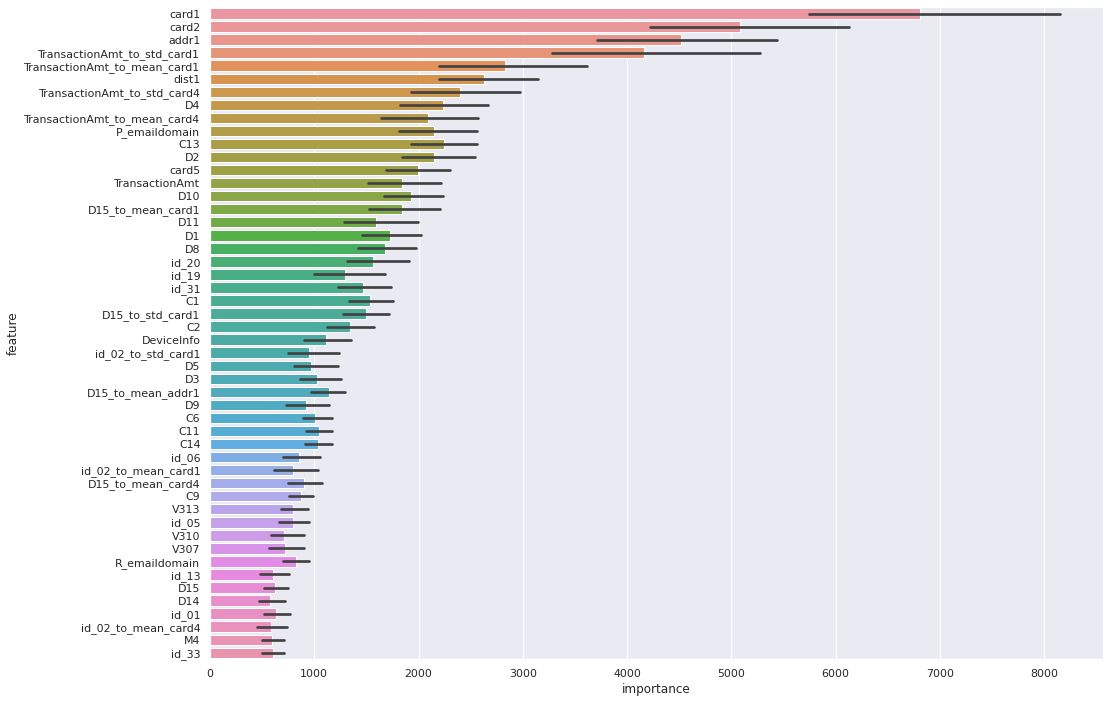

In [0]:
def show_feature_importance(
    models: t.List[lgb.LGBMModel],
    feature_columns: t.List[str]
) -> None:
    df = pd.DataFrame()
    for fold_n, model in enumerate(models):
        df_model = pd.DataFrame()
        df_model["feature"] = feature_columns
        df_model["importance"] = model.feature_importances_
        df_model["fold"] = fold_n
        df = pd.concat([df, df_model], axis=0)

    top_n = 50
    cols = df[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False
    )[:top_n].index
    best_features = df.loc[df["feature"].isin(cols)]
    best_features = best_features.sort_values(by="importance", ascending=False)

    plt.figure(figsize=(16, 12))
    sns.barplot(x="importance", y="feature", data=best_features)
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()


show_feature_importance(result["models"], df_train_x.columns.to_list())

### Prediction

In [0]:
def expand_test(df_train: pd.DataFrame, df_test: pd.DataFrame) -> pd.DataFrame:
    cols_train = df_train.columns.to_list()
    cols_test = df_test.columns.to_list()

    lack_list = list(set(cols_train) - set(cols_test))
    logger.info(pprint.pformat(lack_list))

    df = df_test.copy()
    for name in lack_list:
        df[name] = np.nan
    df = df[cols_train]

    return df


# df_test_x_expand = expand_test(df_train_x, df_test_x)

In [0]:
def show_prediction_result(
    models: t.List[lgb.LGBMModel],
    df_test: pd.DataFrame,
) -> None:
    prediction = np.zeros((len(df_test), 1))
    for model in tqdm.tqdm(models):
        pred = model.predict_proba(df_test)
        prediction += pred[:, 1].reshape(-1, 1)
    prediction /= len(models)

    return prediction


%time pred_test = show_prediction_result(result["models"], df_test_x)


CPU times: user 7min 49s, sys: 625 ms, total: 7min 49s
Wall time: 2min 9s


In [0]:
def create_sub(df_sub: pd.DataFrame, prediction: np.ndarray) -> pd.DataFrame:
    sub = df_sub.copy()
    sub["isFraud"] = prediction

    return sub


df_sub_pred = create_sub(df_sub_org, pred_test)

In [0]:
display.display(df_sub_pred.head())
display.display(df_sub_pred.tail())
logger.info(df_sub_pred.info())

,TransactionID,isFraud
0,3663549,0.001249
1,3663550,0.001660
2,3663551,0.002616
3,3663552,0.001699
4,3663553,0.001978


,TransactionID,isFraud
506686,4170235,0.013320
506687,4170236,0.007390
506688,4170237,0.006694
506689,4170238,0.007044
506690,4170239,0.004798


INFO:__main__:None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  506691 non-null  int64  
 1   isFraud        506691 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 7.7 MB


## Submission

In [0]:
def submit(df_sub: pd.DataFrame, outdir: pathlib.Path, name: str, message: str) -> None:
    outpath = outdir.joinpath("submission.csv")
    df_sub.to_csv(outpath, index=False)
    !kaggle competitions submit "$name" -f "$outpath" -m "$message"


# submit(
#     df_sub_pred,
#     processed_dir,
#     competition_name,
#     "EDA and models StratifiedKFold."
# )

100% 14.1M/14.1M [00:00<00:00, 18.1MB/s]
Successfully submitted to IEEE-CIS Fraud Detection